In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
from rasterstats import zonal_stats

plt.style.use("ggplot")

In [2]:
# Connect to the 'general' database as a 'read-only' user
eng = nivapy.da.connect_postgis()

Connection successful.


# Plot locations of 2022 sensor stations and associated sub-catchments

## Site locations

In [3]:
# Lat/lon co-ords
xl_path = "../data/subcatchments_metadata/outlet_coordinates/tana_2022_sensor_sites_outlet_coords.xlsx"
df = pd.read_excel(xl_path)
df.head()

,site_id,site_name,lat,lon
0,M0,Polmak nye,70.070347,28.016017
1,M4,Anarjohka,69.398450,25.843440
2,M5,Karasjohka,69.397360,25.143640
3,3c,Skierrejohka,69.327242,24.010011
4,9b,Darjohka,69.967678,26.424932


In [19]:
# Convert to geodataframe
pt_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
pt_gdf.to_crs(epsg=25833, inplace=True)
pt_gdf

,site_id,site_name,lat,lon,geometry
0,M0,Polmak nye,70.070347,28.016017,POINT (991882.994 7826523.012)
1,M4,Anarjohka,69.398450,25.843440,POINT (923897.295 7736479.413)
2,M5,Karasjohka,69.397360,25.143640,POINT (896785.005 7731655.128)
3,3c,Skierrejohka,69.327242,24.010011,POINT (853885.290 7716952.400)
4,9b,Darjohka,69.967678,26.424932,POINT (934558.700 7803140.700)
5,13b,Mareveadji,69.199914,25.689413,POINT (921787.270 7713568.930)
6,14,Cærrogæsjokka,69.390031,24.474238,POINT (870914.005 7726639.049)


## Derive catchment boundaries

In [4]:
gdf = nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col="site_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=10,
    dem_res_m=10,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
gdf["catch_area_km2"] = gdf.geometry.area / 1e6
gdf.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/7 [00:00<?, ?it/s]

,site_id,geometry,site_name,lat,lon,catch_area_km2
0,14,"POLYGON ((870070.000 7735440.000, 870100.000 7...",Cærrogæsjokka,69.390031,24.474238,45.3757
1,13b,"POLYGON ((919410.000 7715270.000, 919560.000 7...",Mareveadji,69.199914,25.689413,37.7875
2,3c,"MULTIPOLYGON (((852490.000 7709290.000, 852480...",Skierrejohka,69.327242,24.010011,16.5704
3,9b,"POLYGON ((929980.000 7808250.000, 930700.000 7...",Darjohka,69.967678,26.424932,18.4590
4,M0,"MULTIPOLYGON (((865460.000 7656900.000, 865470...",Polmak nye,70.070347,28.016017,14152.6702


In [6]:
out_shp = r"../data/GIS/shapefiles/catchment_boundaries_sensor_sites_2022.shp"
gdf.to_file(out_shp)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_143/191602379.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_shp)


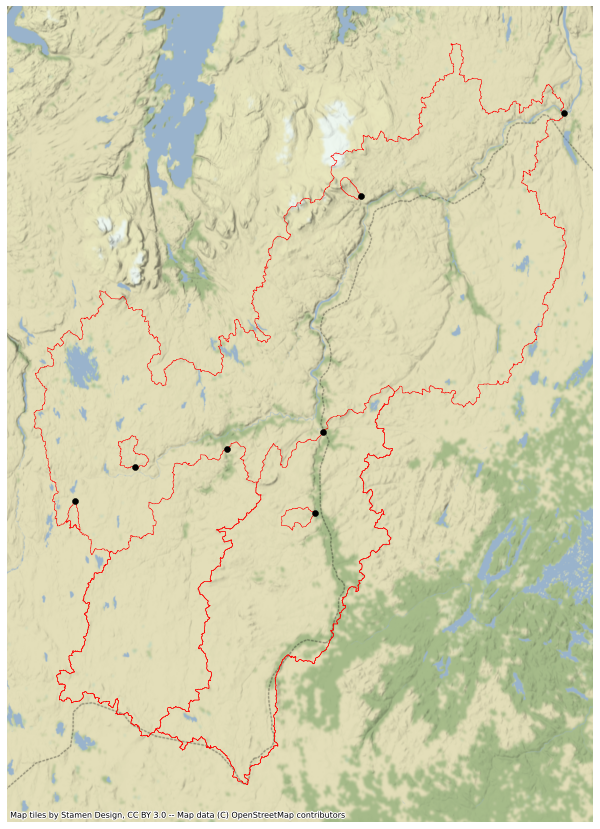

In [26]:
# Plot
ax = gdf.plot(figsize=(15, 15), edgecolor="r", facecolor="none")
pt_gdf.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.Stamen.Terrain)
ax.set_axis_off()
# plt.savefig(r'../output/subcatchment_maps/map_sensor_stations_2022.png', dpi=300)
plt.savefig(r'../output/subcatchment_maps/map_sensor_stations_2022.eps', dpi=300)

## Old workflow

<AxesSubplot:>

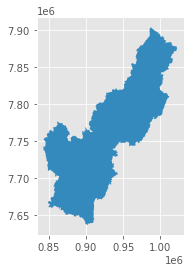

In [23]:
# Get main catchment
fpath = "/home/jovyan/shared/QUANTOM/data/gis/tana_vassdragsomrade.geojson"
vassom_gdf = gpd.read_file(fpath, driver="GeoJSON")
vassom_gdf.plot()

<AxesSubplot:>

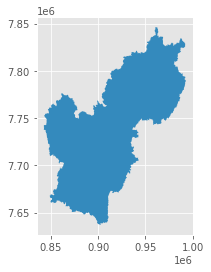

In [24]:
# Polmak
polmak_fpath = r'../data/GIS/shapefiles/Polmak/NedbfeltF_v3.shp'
polmak_gdf = gpd.read_file(polmak_fpath)
polmak_gdf['site_id'] = 'M1'
polmak_gdf['site_name'] = 'Tana_Polmak'
polmak_gdf.set_index('site_id', inplace=True)
# polmak_gdf

In [26]:
# Major southern sub-catchments
southern_rivs_fpath = r"../data/GIS/shapefiles/tana_main_subcatchments.shp"
southern_rivs_gdf = gpd.read_file(main_rivs_fpath)
southern_rivs_gdf.set_index('site_id', inplace=True)
# southern_rivs_gdf

,site_name,lat,lon,catch_area,geometry
site_id,,,,,
M2,Iesjakka,69.42579,24.94077,2081.5829,"MULTIPOLYGON (((864860.000 7702110.000, 864860..."
M4,Anarjohka,69.39845,25.84344,3087.5113,"MULTIPOLYGON (((942470.000 7749590.000, 942480..."
M5,Karasjohka,69.39736,25.14364,2230.3428,"MULTIPOLYGON (((865460.000 7656900.000, 865470..."


/tmp/ipykernel_1224/3043780213.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_rivs_gdf = southern_rivs_gdf.append(polmak_gdf)


<AxesSubplot:>

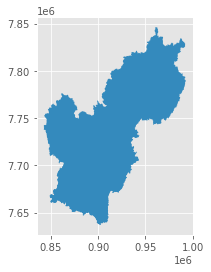

In [29]:
# Join the two and drop M2 (Iesjakka), which isn't being monitored with sensor station in 2022
main_rivs_gdf = southern_rivs_gdf.append(polmak_gdf)
main_rivs_gdf.drop(labels=['M2'], axis=0, inplace=True)
# main_rivs_gdf.plot()

In [34]:
# Add small sub-catchments
small_scs_fpath = r'../data/GIS/shapefiles/catchment_boundaries_2021.shp'
small_scs_gdf = gpd.read_file(small_scs_fpath)
small_scs_gdf.set_index('site_id', inplace=True)

ids_sensors_2022 = ["3c", "9b", "13b", "14"]

small_scs_gdf = small_scs_gdf.loc[ids_sensors_2022]

small_scs_gdf

,vassdragNr,areal_km2,site_name,geometry
site_id,,,,
3c,234.GBCD2Z,15.76,Skierrejohka,"POLYGON ((853805.177 7715715.254, 853880.985 7..."
9b,234.F3A1Z,19.13,Darjohka,"POLYGON ((934679.771 7803284.682, 934587.250 7..."
13b,234.H5Z,38.35,Mareveadji,"POLYGON ((919812.977 7715112.976, 920075.558 7..."
14,234.GBC1Z,44.74,Cearrogeasjohka,"POLYGON ((870152.773 7735461.797, 870411.465 7..."


# Plot

<AxesSubplot:>

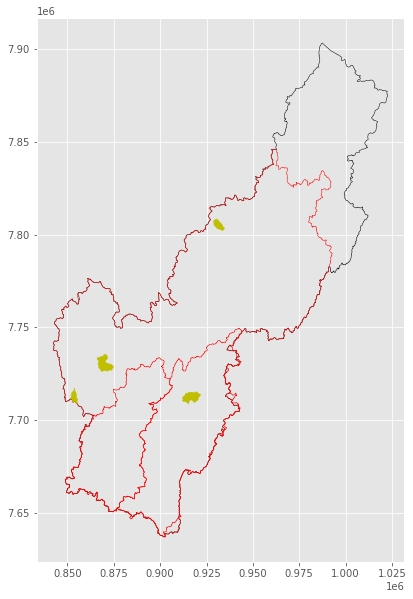

In [43]:
ax = vassom_gdf.plot(figsize=(15, 10), edgecolor="k", facecolor="none")
main_rivs_gdf.plot(ax=ax, edgecolor="r", facecolor="none")
small_scs_gdf.plot(ax=ax, edgecolor="y", facecolor="y")

# cx.add_basemap(ax, crs=main_rivs_gdf.crs, source=cx.providers.Stamen.Terrain)
# ax.set_axis_off()